In [ ]:
#importing libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model

import matplotlib.pyplot as plt
import seaborn as sb

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading and Processing Data

In [ ]:
#path of data set
directory = '/content/drive/My Drive/preproceesed_data_set'

In [ ]:
batch_size = 64
IMG_SIZE = (224, 224, 3)

In [ ]:
#creating train data set
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True,
    )

Found 2940 files belonging to 6 classes.
Using 2352 files for training.


In [ ]:
#creating train validation set
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True
    )

Found 2940 files belonging to 6 classes.
Using 588 files for validation.


In [ ]:
#getting the name of classes
class_names = train_ds.class_names
print(class_names)

['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)']


In [ ]:
#saving class names
np.save("/content/drive/My Drive", class_names)

In [ ]:
NUM_CLASSES = 6

## Sample of Training data

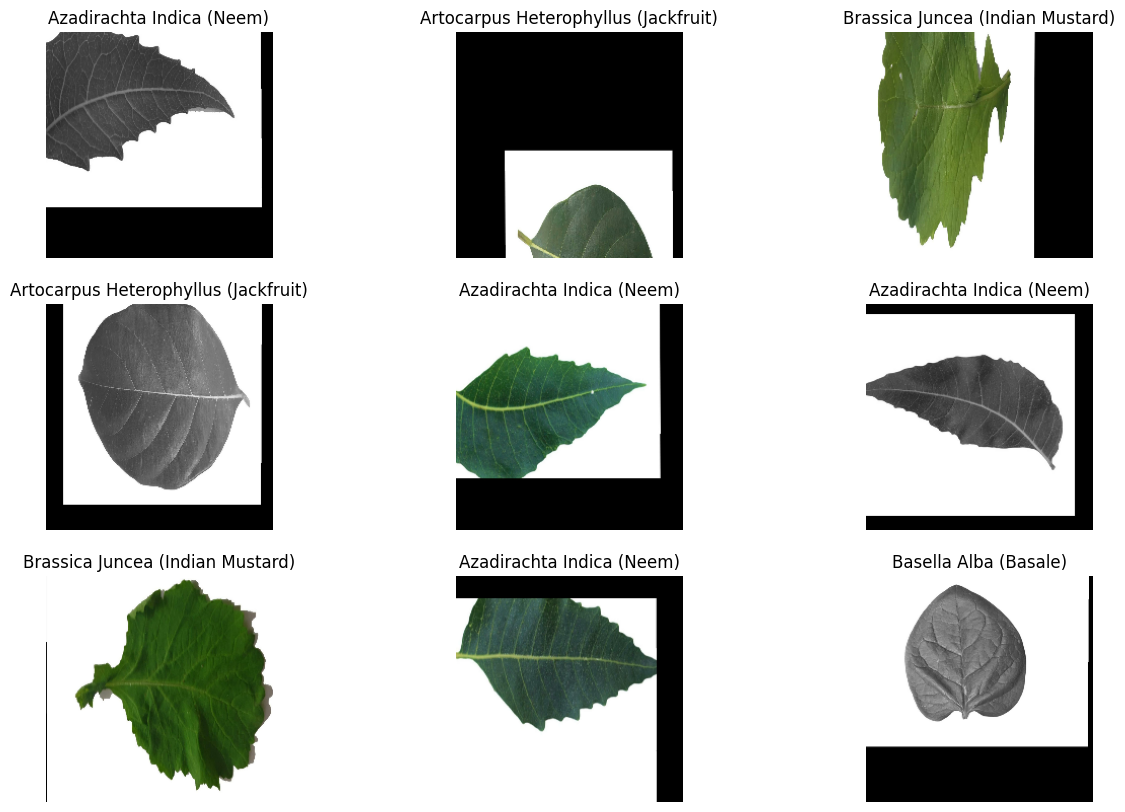

In [ ]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
#provides pipeling for reading data and training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

## Modelling

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

## Using Pre-Trained ResNet50V2

In [ ]:
#ResNet50V2 layers except for the last global average pooling and final dense layer.
pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
           input_tensor=keras.Input(shape=IMG_SIZE))

In [ ]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
#freezing the layers of ResNet
pre_trained_layers.trainable = False

In [ ]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
#Creating custom model
model = keras.Sequential([
    data_augmentation,                                                    # data augmentations
    pre_trained_layers,                                                   # ResNet pre-trained layers
    keras.layers.GlobalAveragePooling2D(),                                # Adding Global average Pooling 2d
    keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')  # Final Dense Layer with 30 neurons
])

In [ ]:
EPOCHS = 20
LR = 1e-3

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#printing summary of custom model
model.build((1,224,224,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 32, 32, 2048)      23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output (Dense)              (None, 6)                 12294     
                                                                 
Total params: 23577094 (89.94 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [ ]:
#training the model
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds, callbacks=callback)

Epoch 1/20


ValueError: ignored

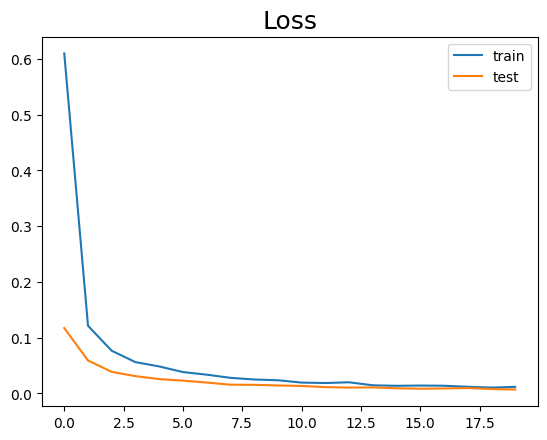

In [ ]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

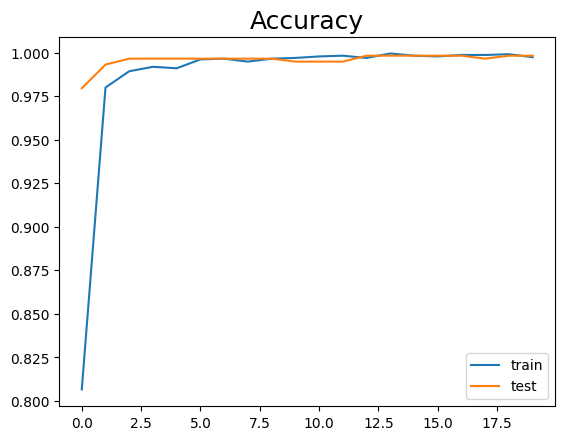

In [ ]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

## Model Performance Analysis

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
Y_train = []
X_train = []

In [ ]:
for data in train_ds:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())

In [ ]:
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

74/74 [==============================] - 12s 114ms/step


In [ ]:
y_train_pred_prob.shape

(2352, 6)

In [ ]:
#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=class_names)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{class_names[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )

    return fig

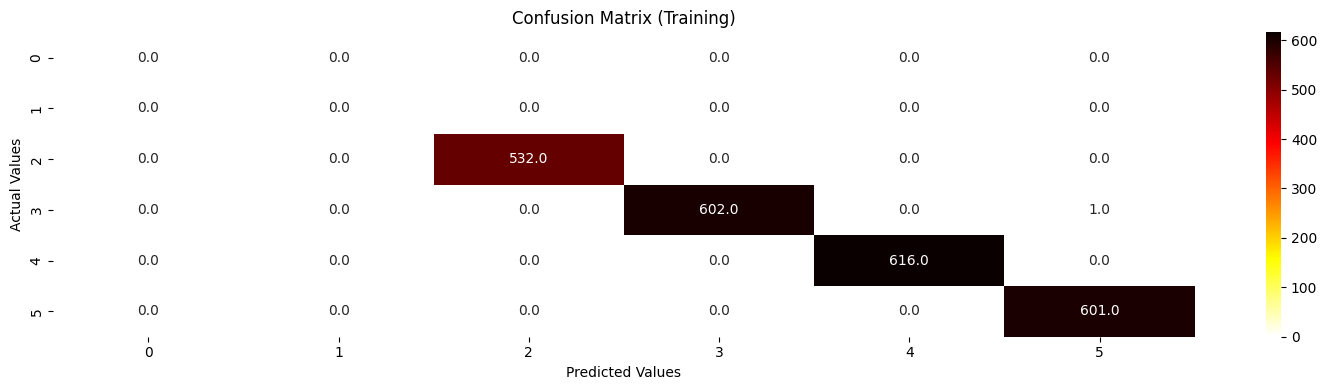

In [ ]:
plt.figure(figsize=(15,4))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

Classification Report for Training
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       532
           3       1.00      1.00      1.00       603
           4       1.00      1.00      1.00       616
           5       1.00      1.00      1.00       601

    accuracy                           1.00      2352
   macro avg       1.00      1.00      1.00      2352
weighted avg       1.00      1.00      1.00      2352



In [ ]:
save_model(model,'/content/drive/My Drive/resnet_6class.h5')
model.save("/content/drive/MyDrive/resnet_6classes_seg.keras")

# **Prediction**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model


model = load_model('/content/drive/My Drive/resnet_6classes_seg.keras')

In [ ]:
import numpy as np

# Create a list of strings
data = ['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)',
        'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)']

# Convert the list to a NumPy array
class_names = np.array(data)

In [ ]:
# class_names = train_ds.class_indices
class_names = list(class_names)
print(class_names)

['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)']


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving basale.jpg to basale.jpg


In [ ]:
import cv2
import numpy as np

image=cv2.imread('/content/basale.jpg')
image_resized=cv2.resize(image,(224,224))
image = np.expand_dims(image_resized, axis = 0)
print(image.shape)

(1, 224, 224, 3)


In [ ]:
pred=model.predict(image)
print(pred)

1/1 [==============================] - 0s 152ms/step
[[0.00067963 0.00170988 0.46994385 0.00781855 0.5189481  0.00089999]]


In [ ]:
output_class=class_names[np.argmax(pred)]
print(output_class)

Basella Alba (Basale)
